# Dynamic Network Graph Exploration 

Explore interactive design and parameters combo to better detect adn define interactions between members. 

Code credits - Yumeng Xi
CHanged based on the original code provided by Xavier Lambein

In [1]:
import os, sys
import logging
import gzip

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import networkx as nx

# Import the data analysis tools
import openbadge_analysis as ob
import openbadge_analysis.preprocessing
import openbadge_analysis.core

SELECTED_BEACON = 12

In [2]:
ob.__version__

'0.4.4'

# Settings
The time_zone variable will be used when converting the timestamp form UTC time to your local time.

In [9]:
time_zone = 'US/Eastern'
log_version = '2.0'
time_bins_size = '1min'

proximity_data_filenames = []

for i in range(1, 18):
    if i < 10:
        filename = 'CTSIserver{:02d}_proximity_2019-06-01.txt'.format(i)
    else:
        filename = 'CTSIserver{}_proximity_2019-06-01.txt'.format(i)
        
    proximity_data_filenames.append(filename)
    
members_metadata_filename = "Member-2019-05-28.csv"
beacons_metadata_filename = "location table.xlsx"
data_dir = "../proximity_2019-06-01/"

# Pre-processing

First, we load two lists that will help us with some of the analysis: list of membmers and list of location beacons

In [10]:
members_metadata = pd.read_csv(data_dir+members_metadata_filename)
beacons_metadata = pd.read_excel(data_dir+beacons_metadata_filename, sheet_name='Sheet1')

# Calculating the id of the beacon based on it's MAC address
# beacons_metadata['id'] = beacons_metadata.apply(
#     lambda row: ob.core.mac_address_to_id(row['badge_address']),
#     axis=1
# )

## beacons_metadata

We create a translation table between the badge ID and member key. This is done based on the data itself, since it should contain data from all the badges that take part in the study. 

Note that we create a <id,member key> pair for ever time bin. While this is not necessary at this point, it allows this mapping to change (for example, if a badge is re-assigned to a different member).

In [11]:
idmaps = []

for proximity_data_filename in proximity_data_filenames:
    with open(os.path.join(data_dir, proximity_data_filename), 'r') as f:
        idmaps.append(ob.preprocessing.id_to_member_mapping(f, time_bins_size, tz=time_zone))
        
tmp_idmaps = idmaps[0]
for i in range(1, len(idmaps)):
    tmp_idmaps = pd.concat([tmp_idmaps, idmaps[i]])

In [12]:
tmp_idmaps.shape

(414366L,)

Using this translation table and the proximity data, we can create a list of "pings" - every time two badges were in close proximity

In [13]:
m2badges = []

for proximity_data_filename in proximity_data_filenames:
    with open(os.path.join(data_dir, proximity_data_filename), 'r') as f:
        m2badges.append(ob.preprocessing.member_to_badge_proximity(f, time_bins_size, tz=time_zone))
        
tmp_m2badges = m2badges[0]

for i in range(1, len(m2badges)):
    tmp_m2badges = pd.concat([tmp_m2badges, m2badges[i]])

In [14]:
tmp_m2badges.shape

(4593629, 2)

Since a badge can either be a badge worn by a participant, or a location beacon, we split the dataset into member-to-member (for network graphs) and member-to-beacon (for localization)

In [15]:
# Member to member
m2ms = []
for (m2badge, idmap) in zip(m2badges, idmaps):
    m2ms.append(ob.preprocessing.member_to_member_proximity(m2badge, idmap))
    
tmp_m2ms = m2ms[0]
for i in range(1, len(m2ms)):
    tmp_m2ms = pd.concat([tmp_m2ms, m2ms[i]])

In [16]:
tmp_m2ms.shape

(1616926, 4)

In [17]:
# Member to location beacon
m2bs = []
for m2badge in m2badges:
    m2bs.append(ob.preprocessing.member_to_beacon_proximity(m2badge, beacons_metadata.set_index('id')['beacon']))
    
tmp_m2bs = m2bs[0]
for i in range(1, len(m2bs)):
    tmp_m2bs = pd.concat([tmp_m2bs, m2bs[i]])

 Member 5 closest beacons

In [18]:
m5cb = tmp_m2bs.reset_index().groupby(['datetime', 'member'])['rssi', 'beacon'] \
        .apply(lambda x: x.nlargest(5, columns=['rssi']) \
        .reset_index(drop=True)[['beacon']]).unstack()['beacon'].fillna(-1).astype(int)

Next, we extract voltage data from the files. This information can be used for monitoring purposes and for identifying badges that ran out of power prematurely.

In [19]:
with open(os.path.join(data_dir, proximity_data_filenames[SELECTED_BEACON]), 'r') as f:
    voltages = ob.preprocessing.voltages(f, time_bins_size, tz=time_zone)

## Network graph
This example shows how to build a basic proximity network using the badge data.

In [20]:
tmp_m2ms_sorted = tmp_m2ms.sort_index(0,0)

In [21]:
# Filter data from specific time period

time_slice = slice('2019-06-01 10:00', '2019-06-01 11:20')
m2m_breakout = tmp_m2ms_sorted.loc[time_slice]

# keep only instances with strong signal
m2m_filter_rssi = m2m_breakout[m2m_breakout.rssi >= -70].copy()
print(len(m2m_filter_rssi))

34230


In [22]:
# Count number of time members were in close proximity
# We name the count column "weight" so that networkx will use it as weight for the spring layout
m2m_edges = m2m_filter_rssi.groupby(['member1', 'member2'])[['rssi_weighted_mean']].count().rename(columns={'rssi_weighted_mean':'weight'})
m2m_edges = m2m_edges[["weight"]].reset_index()

# Keep strongest edges (threshold set manually)
m2m_edges = m2m_edges[m2m_edges.weight > 15]
print(len(m2m_edges))

# Create a graph
graph=nx.from_pandas_edgelist(m2m_edges, "member1", "member2", "weight")

516


In [23]:
# set colors by region
regions = members_metadata["region"].unique()
len_regions = len(regions)
value_map = {}
for i in range(0,len_regions):
    value_map[regions[i]] = i * (1.0/(len_regions-1))

In [24]:
# Add node information. Assign color
for index, row in members_metadata.iterrows():
    member = row["member"]
    region = row["region"]
    color = value_map.get(region)
    if member in graph.nodes():        
        graph.add_node(member, region=region, color = color)
        
node_colors = [color for member,color in nx.get_node_attributes(graph, 'color').iteritems()]

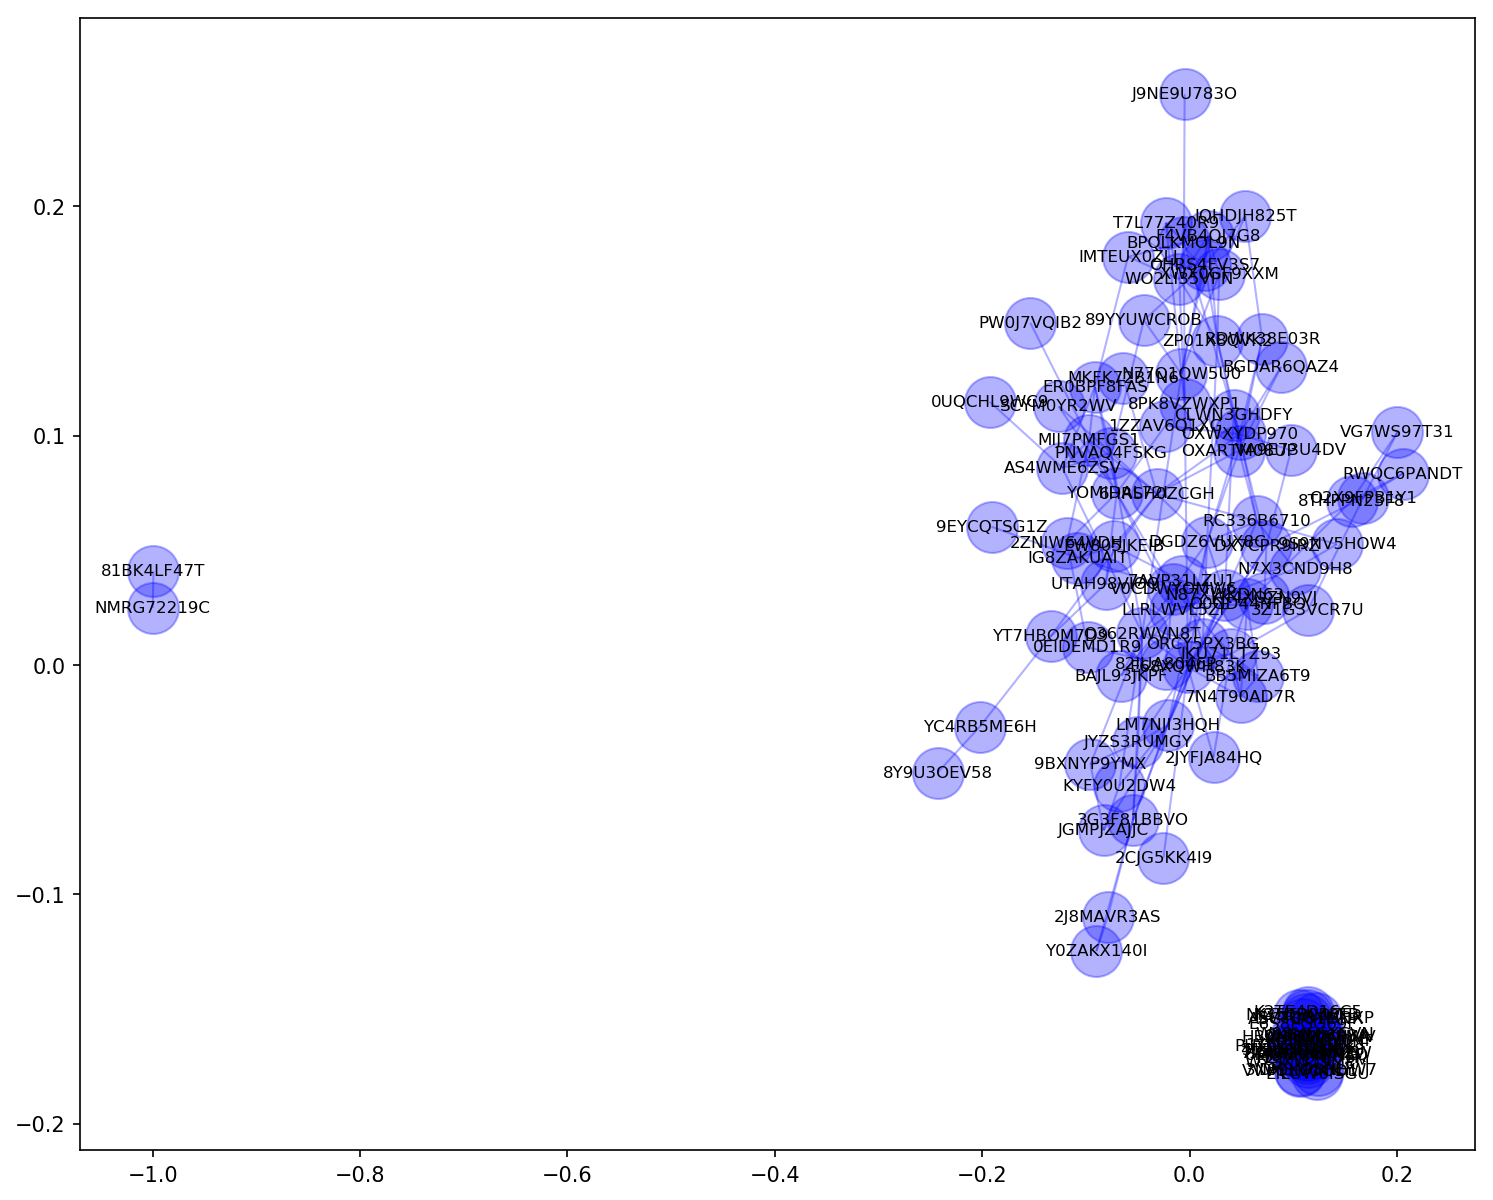

In [25]:
def draw_graph(G, graph_layout='shell',
               node_size=600, node_color='blue', node_alpha=0.3,
               node_text_size=8,
               edge_color='blue', edge_alpha=0.3, edge_tickness=1,
               edge_text_pos=0.3,
               text_font='sans-serif'):

    # these are different layouts for the network you may try
    # shell seems to work best
    if graph_layout == 'spring':
        graph_pos=nx.spring_layout(G)
    elif graph_layout == 'spectral':
        graph_pos=nx.spectral_layout(G)
    elif graph_layout == 'random':
        graph_pos=nx.random_layout(G)
    else:
        graph_pos=nx.shell_layout(G)

    # draw graph
    nx.draw_networkx_nodes(G,graph_pos,node_size=node_size, 
                           alpha=node_alpha, node_color=node_color, cmap=plt.get_cmap('jet'))
    nx.draw_networkx_edges(G,graph_pos,width=edge_tickness,
                           alpha=edge_alpha,edge_color=edge_color)
    nx.draw_networkx_labels(G, graph_pos,font_size=node_text_size,
                            font_family=text_font)

    plt.show()

fig = plt.figure(figsize=(12, 10), dpi=150)
ax = plt.subplot(1,1,1)

draw_graph(graph, graph_layout="spring")

In [27]:
from pyvis.network import Network
#try time slice iteratively
# Filter data from specific time period
time_slices=[slice('2019-06-01 9:50', '2019-06-01 10:00'),slice('2019-06-01 10:00', '2019-06-01 10:10'),
             slice('2019-06-01 10:10', '2019-06-01 10:20'),slice('2019-06-01 10:20', '2019-06-01 10:30'),
             slice('2019-06-01 10:30', '2019-06-01 10:40'),slice('2019-06-01 10:40', '2019-06-01 10:50'),
             slice('2019-06-01 10:50', '2019-06-01 11:00'),slice('2019-06-01 11:00', '2019-06-01 11:10'),
             slice('2019-06-01 11:10', '2019-06-01 11:20')]
for i in range(1,10):
    time_slice = time_slices[i-1]
    m2m_breakout = tmp_m2ms_sorted.loc[time_slice]
    # keep only instances with strong signal
    m2m_filter_rssi = m2m_breakout[m2m_breakout.rssi >= -70].copy()
    print(len(m2m_filter_rssi))
    # Count number of time members were in close proximity
    # We name the count column "weight" so that networkx will use it as weight for the spring layout
    m2m_edges = m2m_filter_rssi.groupby(['member1', 'member2'])[['rssi_weighted_mean']
                                                               ].count().rename(columns={'rssi_weighted_mean':'weight'})
    m2m_edges = m2m_edges[["weight"]].reset_index()
    # Keep strongest edges (threshold set manually)
    m2m_edges = m2m_edges[m2m_edges.weight > 5]
    print(len(m2m_edges))
    # Create a graph
    graph=nx.from_pandas_edgelist(m2m_edges, "member1", "member2", "weight")
#     fig = plt.figure(figsize=(12,90), dpi=150)
#     ax = plt.subplot(10,1,i)
#     draw_graph(graph, graph_layout="spring",node_size=40)
    net = Network(height="750px", width="100%", bgcolor="#222222", font_color="white")
    net.from_nx(graph) 
#     net.show_buttons()
    net.set_options('''
    var options = {
  "nodes": {
    "size": 12
  },
  "edges": {
    "color": {
      "inherit": true
    },
    "smooth": false
  },
  "interaction": {
    "hover": true,
    "keyboard": {
      "enabled": true
    },
    "navigationButtons": true,
    "tooltipDelay": 1000
  },
  "manipulation": {
    "enabled": true,
    "initiallyActive": true
  },
  "physics": {
    "minVelocity": 0.75
  }
}
    ''')
    net.show("Interactivenetworkx{}.html".format(i))
   
#plt.show()




4838
419
4976
434
4849
422
4834
421
4709
396
4844
385
4594
396
4412
382
4033
336


# Lunch Time Analysis
Use data from lunch time to find the definition of close interaction 

In [ ]:
#try time slice iteratively
# Filter data from specific time period
time_slices=[slice('2019-06-01 11:30', '2019-06-01 11:35'),slice('2019-06-01 11:35', '2019-06-01 11:40'),
             slice('2019-06-01 11:40', '2019-06-01 11:45'),slice('2019-06-01 11:45', '2019-06-01 11:50'),
             slice('2019-06-01 11:50', '2019-06-01 11:55'),slice('2019-06-01 11:55', '2019-06-01 12:00'),
            slice('2019-06-01 12:00', '2019-06-01 12:05'),slice('2019-06-01 12:05', '2019-06-01 12:10'),
            slice('2019-06-01 12:10', '2019-06-01 12:15'),slice('2019-06-01 12:15', '2019-06-01 12:20'),]
for i in range(1,11):
    time_slice = time_slices[i-1]
    m2m_breakout = tmp_m2ms_sorted.loc[time_slice]
    # keep only instances with strong signal
    m2m_filter_rssi = m2m_breakout[m2m_breakout.rssi >= -71].copy()
    print(len(m2m_filter_rssi))
    # Count number of time members were in close proximity
    # We name the count column "weight" so that networkx will use it as weight for the spring layout
    m2m_edges = m2m_filter_rssi.groupby(['member1', 'member2'])[['rssi_weighted_mean']
                                                               ].count().rename(columns={'rssi_weighted_mean':'weight'})
    m2m_edges = m2m_edges[["weight"]].reset_index()
    # Keep strongest edges (threshold set manually)
    m2m_edges = m2m_edges[m2m_edges.weight > 10]
    print(len(m2m_edges))
    # Create a graph
    graph=nx.from_pandas_edgelist(m2m_edges, "member1", "member2", "weight")
#     fig = plt.figure(figsize=(12,90), dpi=150)
#     ax = plt.subplot(10,1,i)
#     draw_graph(graph, graph_layout="spring",node_size=40)
    net = Network(height="750px", width="100%", bgcolor="#222222", font_color="white")
    net.from_nx(graph) 
#     net.show_buttons()
    net.set_options('''
    var options = {
  "nodes": {
    "size": 12
  },
  "edges": {
    "color": {
      "inherit": true
    },
    "smooth": false
  },
  "interaction": {
    "hover": true,
    "keyboard": {
      "enabled": true
    },
    "navigationButtons": true,
    "tooltipDelay": 1000
  },
  "manipulation": {
    "enabled": true,
    "initiallyActive": true
  },
  "physics": {
    "minVelocity": 0.75
  }
}
    ''')
    net.show("Interactivenetworkx{}.html".format(i))
   
#plt.show()


